<a href="https://colab.research.google.com/github/atlasrikanth/BEIJING_AQI_Prediction/blob/main/BEIJING_AQI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from google.colab import files
%matplotlib inline

In [9]:
# Cell 3: Upload dataset
uploaded = files.upload()

# Load dataset
df = pd.read_csv('PRSA_Data_Aotizhongxin_20130301-20170228.csv')

# Display first few rows
print("Dataset Head:")
print(df.head())

# Check dataset info
print("\nDataset Info:")
df.info()

# Summary statistics
print("\nDataset Description:")
print(df.describe())

Saving PRSA_Data_Aotizhongxin_20130301-20170228.csv to PRSA_Data_Aotizhongxin_20130301-20170228.csv
Dataset Head:
   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   

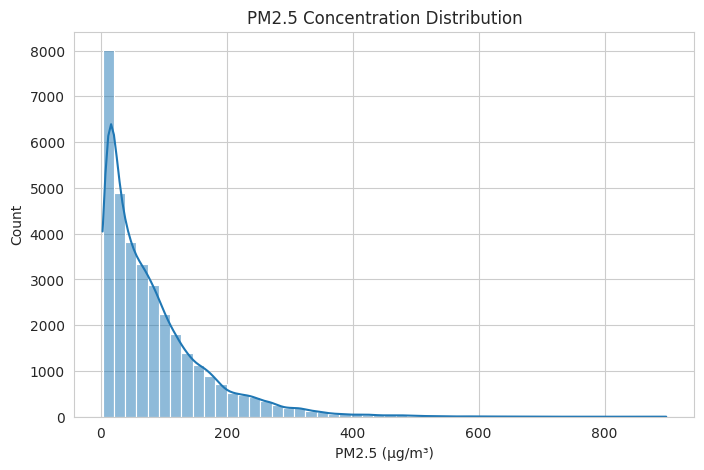

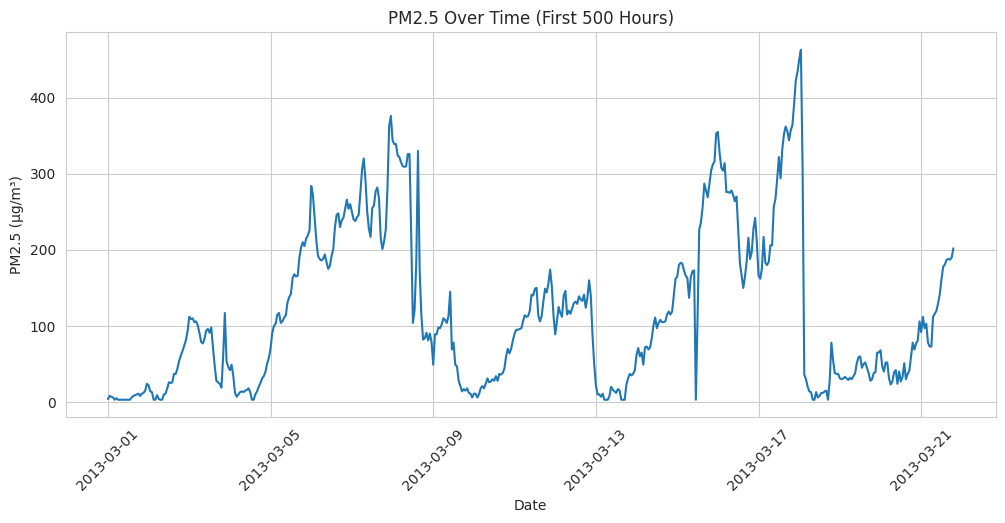

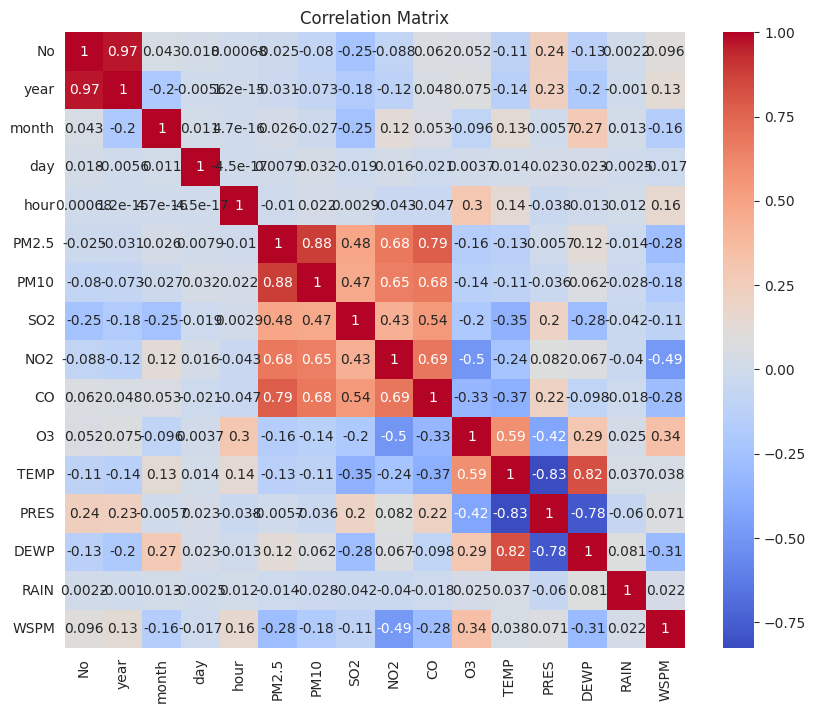

In [10]:
# Cell 4: Data visualization
# Set plot style
sns.set_style('whitegrid')

# Plot PM2.5 distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['PM2.5'].dropna(), bins=50, kde=True)
plt.title('PM2.5 Concentration Distribution')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()

# Plot PM2.5 over time (sample)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
plt.figure(figsize=(12, 5))
plt.plot(df['datetime'][:500], df['PM2.5'][:500])
plt.title('PM2.5 Over Time (First 500 Hours)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(rotation=45)
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Cell 5: Preprocessing
# Ensure required libraries are imported
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows with missing PM2.5 (target) and create a new DataFrame
df_clean = df.dropna(subset=['PM2.5']).copy()

# Create cyclical temporal features
df_clean.loc[:, 'datetime'] = pd.to_datetime(df_clean[['year', 'month', 'day', 'hour']])
df_clean.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)
df_clean.loc[:, 'month_sin'] = np.sin(2 * np.pi * df_clean['month'] / 12)
df_clean.loc[:, 'month_cos'] = np.cos(2 * np.pi * df_clean['month'] / 12)

# Select features
features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wd']
X = df_clean[features]
y = df_clean['PM2.5']

# Impute missing numerical values
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
X.loc[:, num_cols] = imputer_num.fit_transform(X[num_cols])

# Encode wind direction (wd)
X.loc[:, 'wd'] = X['wd'].fillna(X['wd'].mode()[0])
le = LabelEncoder()
X.loc[:, 'wd'] = le.fit_transform(X['wd'])

# Scale features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify data
print("Preprocessing complete.")
print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Training target shape:", y_train.shape)
print("Missing values in X_train:", X_train.isnull().sum().sum())

Preprocessing complete.
Training features shape: (27311, 15)
Validation features shape: (6828, 15)
Training target shape: (27311,)
Missing values in X_train: 0


In [15]:
# Cell 6: Train baseline models
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_val, lr_pred)))
print("Linear Regression R²:", r2_score(y_val, lr_pred))

# Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
print("\nRandom Forest RMSE:", np.sqrt(mean_squared_error(y_val, rf_pred)))
print("Random Forest R²:", r2_score(y_val, rf_pred))

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)
print("\nXGBoost RMSE:", np.sqrt(mean_squared_error(y_val, xgb_pred)))
print("XGBoost R²:", r2_score(y_val, xgb_pred))

Linear Regression RMSE: 31.07085669072815
Linear Regression R²: 0.855969956691485

Random Forest RMSE: 20.867976835057313
Random Forest R²: 0.9350308286680977

XGBoost RMSE: 19.624009918787042
XGBoost R²: 0.9425457519608712


In [16]:
# Cell 7: Hyperparameter tuning
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, preds))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train final model
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X, y)

[I 2025-07-08 12:41:28,138] A new study created in memory with name: no-name-5c866239-642d-4d15-98e5-786f4e647f27
[I 2025-07-08 12:41:36,223] Trial 0 finished with value: 18.681933331797126 and parameters: {'n_estimators': 194, 'max_depth': 10, 'learning_rate': 0.10112826946237388, 'subsample': 0.7541198585875575, 'colsample_bytree': 0.8851876345822698}. Best is trial 0 with value: 18.681933331797126.
[I 2025-07-08 12:41:37,130] Trial 1 finished with value: 19.49903600637951 and parameters: {'n_estimators': 73, 'max_depth': 9, 'learning_rate': 0.11821924485364056, 'subsample': 0.549044946953692, 'colsample_bytree': 0.79021336196165}. Best is trial 0 with value: 18.681933331797126.
[I 2025-07-08 12:41:40,769] Trial 2 finished with value: 19.08678320917359 and parameters: {'n_estimators': 138, 'max_depth': 10, 'learning_rate': 0.25313471291650586, 'subsample': 0.8125612164097833, 'colsample_bytree': 0.8032288683585954}. Best is trial 0 with value: 18.681933331797126.
[I 2025-07-08 12:41:

Best parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.21291971636524687, 'subsample': 0.9746425606083078, 'colsample_bytree': 0.991469441733106}
Best RMSE: 18.072207894313845


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.991469441733106, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.21291971636524687, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

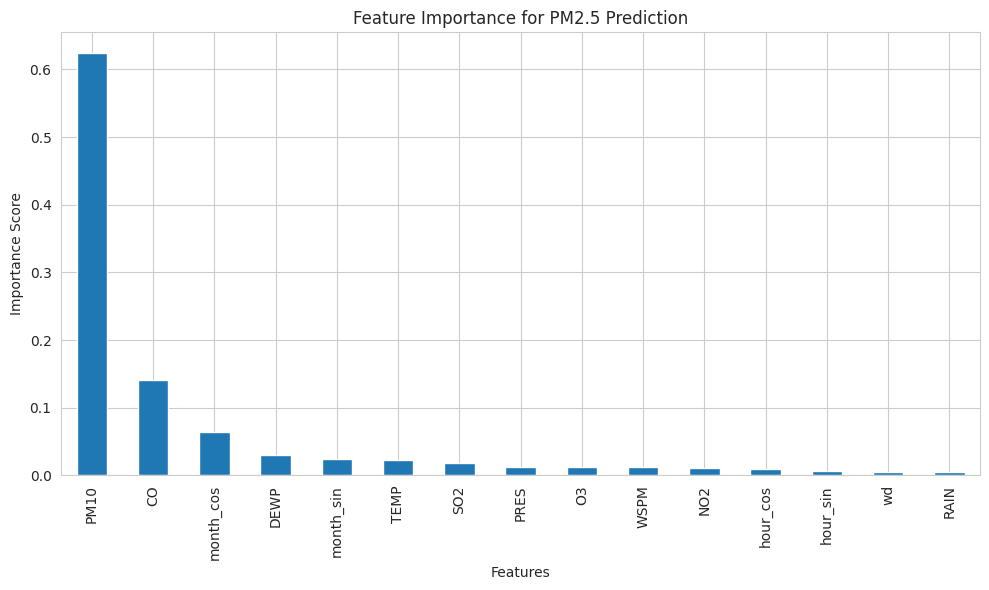

In [17]:
# Cell 8: Feature importance
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
feature_importance = pd.Series(final_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance for PM2.5 Prediction')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [18]:
# Cell 9: Cross-validation
import numpy as np
from sklearn.model_selection import cross_val_score

# Define custom scorer for RMSE
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_scores = cross_val_score(final_model, X, y, cv=5, scoring=rmse_scorer)
cv_scores = np.sqrt(-cv_scores)  # Convert to RMSE
print("Cross-Validation RMSE Scores:", cv_scores)
print("Mean CV RMSE:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Cross-Validation RMSE Scores: [32.79884586 28.74373102 26.19565038 28.44154431 20.8761317 ]
Mean CV RMSE: 27.41118065489482
Standard Deviation: 3.8999655055695315


In [19]:
# Cell 10: Save predictions
from google.colab import files
import pandas as pd

val_preds = final_model.predict(X_val)
results = pd.DataFrame({'Actual': y_val, 'Predicted': val_preds})
results.to_csv('pm25_predictions.csv', index=False)
files.download('pm25_predictions.csv')
print("Predictions saved and downloaded as pm25_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved and downloaded as pm25_predictions.csv


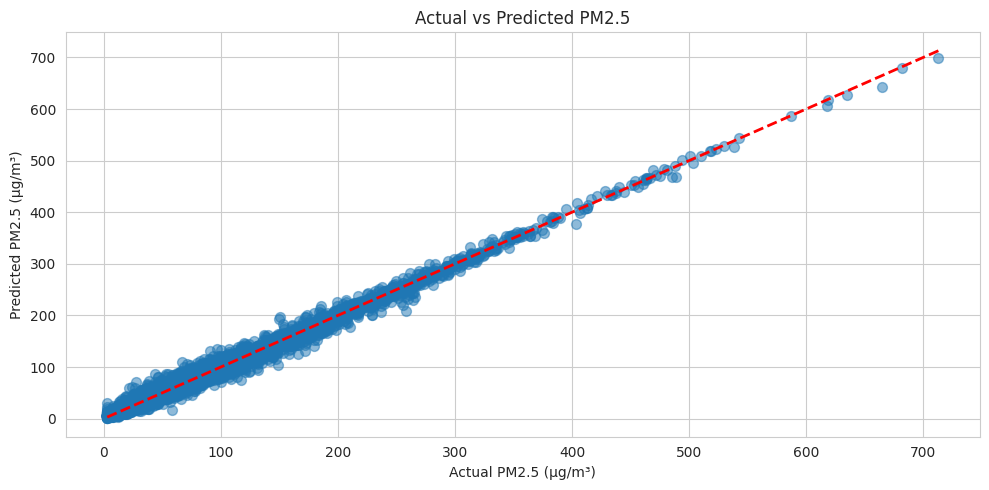

In [20]:
# Cell 11: Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_val, val_preds, alpha=0.5, s=50)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5 (µg/m³)')
plt.ylabel('Predicted PM2.5 (µg/m³)')
plt.title('Actual vs Predicted PM2.5')
plt.grid(True)
plt.tight_layout()
plt.show()